In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import style
import pandas_datareader.data as web

In [3]:
pip install pandas_datareader

  Using cached https://files.pythonhosted.org/packages/14/52/accb990baebe0063977f26e02df36aa7eb4015ed4e86f828cd76273cd6f1/pandas_datareader-0.8.1-py2.py3-none-any.whl
     |████████████████████████████████| 4.5MB 2.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


             High        Low       Open      Close    Volume  Adj Close
Date                                                                   
2010-06-29  25.00  17.540001  19.000000  23.889999  18766300  23.889999
2010-06-30  30.42  23.299999  25.790001  23.830000  17187100  23.830000
2010-07-01  25.92  20.270000  25.000000  21.959999   8218800  21.959999
2010-07-02  23.10  18.709999  23.000000  19.200001   5139800  19.200001
2010-07-06  20.00  15.830000  20.000000  16.110001   6866900  16.110001
                  High         Low        Open       Close    Volume  \
Date                                                                   
2019-12-24  425.470001  412.690002  418.359985  425.250000   8054700   
2019-12-26  433.480011  426.350006  427.910004  430.940002  10633900   
2019-12-27  435.309998  426.109985  435.000000  430.380005   9945700   
2019-12-30  429.000000  409.260010  428.790009  414.700012  12586400   
2019-12-31  421.290009  402.079987  405.000000  418.329987  1028

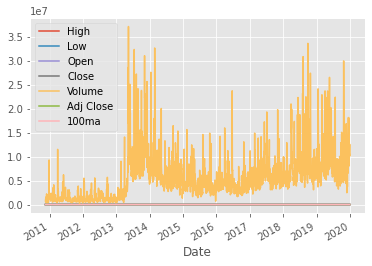

(2295,)


In [7]:
style.use("ggplot")
start = dt.datetime(2010,1,1)
end = dt.datetime(2020,1,1)
df = web.DataReader("TSlA","yahoo",start,end)
print(df.head())
print(df.tail())
df["100ma"]=df["Adj Close"].rolling(window=100).mean()
df.dropna(inplace=True)
print(df.head())
df.plot()
plt.show()
series = df['Open'].to_numpy()
print(series.shape)

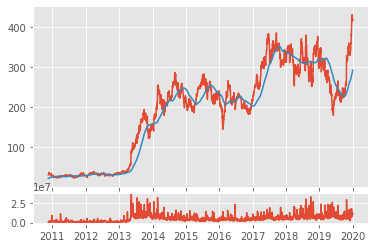

In [12]:
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=5,colspan=1,sharex=ax1)
ax1.plot(df.index,df["Adj Close"])
ax1.plot(df.index,df["100ma"])
ax2.plot(df.index,df["Volume"])

In [27]:
pip install mplfinance

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [56]:
import mplfinance as mpl
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

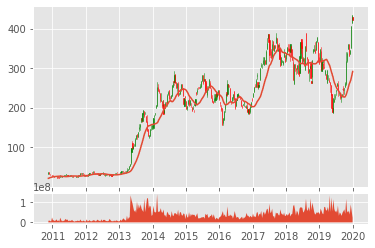

In [58]:
df_ohlc = df.resample("10D").ohlc()
df_vol = df["Volume"].resample("10D").sum()


df_ohlc.reset_index(inplace=True)
df_ohlc["Date"] = df_ohlc["Date"].map(mdates.date2num)


ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=5,colspan=1,sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1,df_ohlc.values,width=2,colorup="g")
ax2.fill_between(df_vol.index.map(mdates.date2num),df_vol.values,0)
ax1.plot(df.index,df["100ma"])
plt.show()

In [14]:
import tensorflow as tf

In [10]:
time = np.arange(2295, dtype="float32")
split_time = 2000
time_train = time[:split_time]
print(time_train.shape)
x_train = series[:split_time]
time_valid = time[split_time:]
print(time_valid.shape)
x_valid = series[split_time:]

print(x_train.shape)
print(x_valid.shape)

(2000,)
(295,)
(2000,)
(295,)


In [22]:
window_size = 20
batch_size = 20
shuffle_buffer = 2

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
windowed_dataset(series, window_size, batch_size, shuffle_buffer)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [38]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


In [33]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

[[430.48886]]


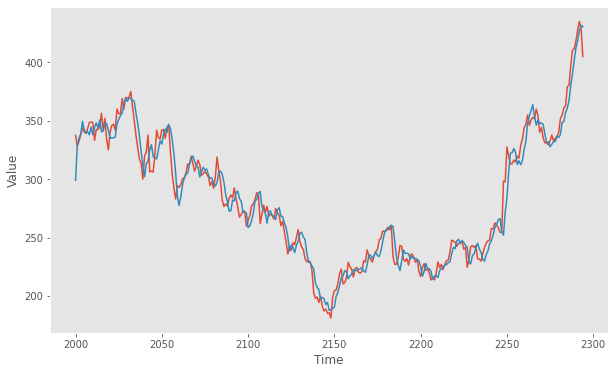

In [41]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(forecast[-1])


In [40]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.202362

(1e-08, 0.001, 0.0, 300.0)

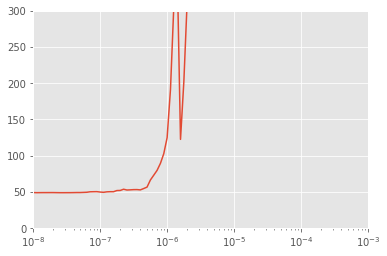

In [36]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

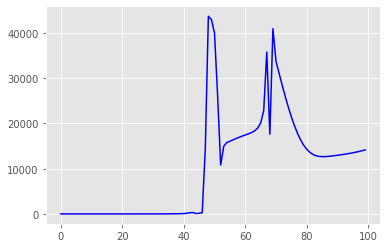

In [37]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()